# Problem 3
We will first setup different parts of our stack before the problem. You will only be writing code and answering questions in Part 4 of this notebook. You should however follow along with the code and text in Parts 1 - 3 to understand the problem setup as you will need to use it to write your code for Part 4. You are also welcome and encouraged to look at the visualization code if interested, but you will not be required to edit or write it to complete this problem.

At a high level, in this notebook we will:


1.   Set up a class for simulating the dynamics of a planar quadrotor (drone) and for visualizing its trajectory
2.   Write a direct method  to compute a nominal trajectory for the quadrotor to move from a starting position to an end position while avoiding an obstacle. Recall that the nominal trajectory assumes that the environment has no disturbances and the plan can be followed perfectly.
3. Simulate what will occur if a quadrotor follows this nominal trajectory in the presence of a wind disturbance
4. (Your task) Write a gain scheduled LQR algorithm that allows the quadrotor to correct its course as it tries to track the nominal trajectory in the presence of the wind disturbance.

Let's begin!


## Part 1 - Setting Up Dynamics and Quadrotor Trajectory Visualization
In this problem we'll consider a planar (i.e., 2D) quadrotor depicted below

![](https://drive.google.com/uc?export=view&id=1UnEFIpfZWnToer0hIbKAYmKJXrBv5MIE)

with (continuous-time) nonlinear dynamics described by the ODE
$$
    \begin{bmatrix}
      \dot x \\ \dot v_x \\ \dot y \\ \dot v_y \\ \dot \phi \\ \dot \omega
    \end{bmatrix} =
    \begin{bmatrix}
      v_x \\
      \frac{-(T_1 + T_2) \sin\phi - C_D^v v_x}{m} \\
      v_y \\
      \frac{(T_1 + T_2) \cos\phi - C_D^v v_y}{m}  - g \\
      \omega \\
      \frac{(T_2 - T_1) \ell - C_D^\phi \omega}{I_{yy}}
    \end{bmatrix}, \quad T_1, T_2 \in [0, T_{\max}],
$$
where the state is given by the position in the vertical plane $(x, y)$, translational velocity $(v_x, v_y)$, pitch $\phi$, and pitch rate $\omega$; the controls are the thrusts $(T_1, T_2)$ for the left and right prop respectively. Additional constants appearing in the dynamics above are gravitational acceleration $g$, the quadrotor's mass $m$, moment of inertia (about the out-of-plane axis) $I_{yy}$, half-length $\ell$, and translational and rotational drag coefficients $C_D^v$ and $C_D^\phi$, respectively (see the code below for precise values of these constants).

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np

class BasePlanarQuadrotor:

    def __init__(self):
        # Dynamics constants
        self.x_dim = 6         # state dimension (see dynamics below)
        self.u_dim = 2         # control dimension (see dynamics below)
        self.g = 9.807         # gravity (m / s**2)
        self.m = 2.5           # mass (kg)
        self.l = 1.0           # half-length (m)
        self.Iyy = 1.0         # moment of inertia about the out-of-plane axis (kg * m**2)
        self.Cd_v = 0.25       # translational drag coefficient
        self.Cd_phi = 0.02255  # rotational drag coefficient

        # Control constraints
        self.max_thrust_per_prop = 0.75 * self.m * self.g  # total thrust-to-weight ratio = 1.5
        self.min_thrust_per_prop = 0  # at least until variable-pitch quadrotors become mainstream :D

    def ode(self, state, control):
        """Continuous-time dynamics of a planar quadrotor expressed as an ODE."""
        x, v_x, y, v_y, phi, omega = state
        T_1, T_2 = control
        return np.array([
            v_x,
            (-(T_1 + T_2) * np.sin(phi) - self.Cd_v * v_x) / self.m,
            v_y,
            ((T_1 + T_2) * np.cos(phi) - self.Cd_v * v_y) / self.m - self.g,
            omega,
            ((T_2 - T_1) * self.l - self.Cd_phi * omega) / self.Iyy,
        ])

    def discrete_step(self, state, control, dt):
        """Discrete-time dynamics (Euler-integrated) of a planar quadrotor."""
        # RK4 would be more accurate, but this runs more quickly in a homework problem;
        # in this notebook we use Euler integration for both control and simulation for
        # illustrative purposes (i.e., so that planning and simulation match exactly).
        # Often simulation may use higher fidelity models than those used for planning/
        # control, e.g., using `scipy.integrate.odeint` here for much more accurate
        # (and expensive) integration.
        return state + dt * self.ode(state, control)

    def get_continuous_jacobians(self, state_nominal, control_nominal):
        """Continuous-time Jacobians of planar quadrotor, written as a function of input state and control"""
        x, v_x, y, v_y, phi, omega = state_nominal
        T_1, T_2 = control_nominal
        A = np.array([[0., 1., 0., 0., 0., 0.],
                    [0., -self.Cd_v/self.m, 0., 0., -(T_1 + T_2)*np.cos(phi)/self.m, 0.],
                    [0., 0., 0., 1., 0., 0.],
                    [0., 0., 0., -self.Cd_v/self.m, -(T_1+T_2)*np.sin(phi)/self.m, 0.],
                    [0., 0., 0., 0., 0., 1.],
                    [0., 0., 0., 0., 0., -self.Cd_phi/self.Iyy]])
        B = np.array([[0., 0.],
                    [-np.sin(phi)/self.m, -np.sin(phi)/self.m],
                    [0., 0.],
                    [np.cos(phi)/self.m, np.cos(phi)/self.m],
                    [0., 0.],
                    [-self.l/self.Iyy, self.l/self.Iyy]])
        return A, B
        

In [2]:
#@title Definition of `PlanarQuadrotor`, which adds code for creating animations on top of `BasePlanarQuadrotor` above.

import matplotlib
import matplotlib.animation
import matplotlib.pyplot as plt

class PlanarQuadrotor(BasePlanarQuadrotor):
    def generate_patch_group(self, frame_height, frame_width, axle_height, axle_width, prop_width, prop_height, hub_width, hub_height):
        # Artists
        frame = matplotlib.patches.Rectangle((-frame_width / 2, -frame_height / 2),
                                             frame_width,
                                             frame_height,
                                             facecolor="tab:blue",
                                             edgecolor="k")
        hub = matplotlib.patches.FancyBboxPatch((-hub_width / 2, -hub_height / 2),
                                                hub_width,
                                                hub_height,
                                                facecolor="tab:blue",
                                                edgecolor="k",
                                                boxstyle="Round,pad=0.,rounding_size=0.05")
        axle_left = matplotlib.patches.Rectangle((-frame_width / 2, frame_height / 2),
                                                 axle_width,
                                                 axle_height,
                                                 facecolor="tab:blue",
                                                 edgecolor="k")
        axle_right = matplotlib.patches.Rectangle((frame_width / 2 - axle_width, frame_height / 2),
                                                  axle_width,
                                                  axle_height,
                                                  facecolor="tab:blue",
                                                  edgecolor="k")
        prop_left = matplotlib.patches.Ellipse(((axle_width - frame_width) / 2, frame_height / 2 + axle_height),
                                               prop_width,
                                               prop_height,
                                               facecolor="tab:gray",
                                               edgecolor="k",
                                               alpha=0.7)
        prop_right = matplotlib.patches.Ellipse(((frame_width - axle_width) / 2, frame_height / 2 + axle_height),
                                                prop_width,
                                                prop_height,
                                                facecolor="tab:gray",
                                                edgecolor="k",
                                                alpha=0.7)
        bubble = matplotlib.patches.Circle((0, 0), 1.5 * self.l, facecolor="None", edgecolor="red", linestyle="--")
        patches = (frame, hub, axle_left, axle_right, prop_left, prop_right, bubble)
        return patches

    def animate(self, states, dt, ax=None):
        x, y, phi = states[:, 0], states[:, 2], states[:, 4]

        frame_width = 2 * self.l
        frame_height = 0.15
        axle_height = 0.2
        axle_width = 0.05
        prop_width = 0.5 * frame_width
        prop_height = 1.5 * frame_height
        hub_width = 0.3 * frame_width
        hub_height = 2.5 * frame_height

        # Figure and axis
        if ax is None:
            fig, ax = plt.subplots(figsize=(12, 6))
        else:
            fig = ax.figure
        x_min, x_max = np.min(x), np.max(x)
        x_pad = (frame_width + prop_width) / 2 + 0.1 * (x_max - x_min)
        y_min, y_max = np.min(y), np.max(y)
        y_pad = (frame_width + prop_width) / 2 + 0.1 * (y_max - y_min)
        ax.set_xlim([x_min - x_pad, x_max + x_pad])
        ax.set_ylim([y_min - y_pad, y_max + y_pad])
        ax.set_aspect(1.)

        ax.plot(x, y)

        for k in range(0,len(states),10):
            patch_group = self.generate_patch_group(frame_height, frame_width, axle_height, axle_width, prop_width, prop_height, hub_width, hub_height)
            transform = matplotlib.transforms.Affine2D().rotate_around(0., 0., phi[k])
            transform += matplotlib.transforms.Affine2D().translate(x[k], y[k])
            transform += ax.transData
            for patch in patch_group:
                patch.set_transform(transform)
                ax.add_patch(patch)

        plt.show()


## Part 2 - Computing a Nominal Trajectory using a Direct Method

In [3]:
#@title Implementation of a direct method for computing a nominal trajectory driving from stable hover at $(x, y) = (0, 5)$ to $(10, 7)$, avoiding an obstacle centered at $(5, 5)$.

import scipy.optimize

def optimize_nominal_trajectory(N=50, return_optimize_result=False):
    planar_quad = PlanarQuadrotor()
    x_0 = np.array([0., 0., 5., 0., 0., 0.])
    x_f = np.array([10., 0., 7., 0., 0., 0.])

    equilibrium_thrust = 0.5 * planar_quad.m * planar_quad.g
    x_dim = planar_quad.x_dim
    u_dim = planar_quad.u_dim

    def pack_decision_variables(final_time, states, controls):
        """Packs decision variables (final_time, states, controls) into a 1D vector.

        Args:
            final_time: scalar.
            states: array of shape (N + 1, x_dim).
            controls: array of shape (N, u_dim).
        Returns:
            An array `z` of shape (1 + (N + 1) * x_dim + N * u_dim,).
        """
        return np.concatenate([[final_time], states.ravel(), controls.ravel()])

    def unpack_decision_variables(z):
        """Unpacks a 1D vector into decision variables (final_time, states, controls).

        Args:
            z: array of shape (1 + (N + 1) * x_dim + N * u_dim,).
        Returns:
            final_time: scalar.
            states: array of shape (N + 1, x_dim).
            controls: array of shape (N, u_dim).
        """
        final_time = z[0]
        states = z[1:1 + (N + 1) * x_dim].reshape(N + 1, x_dim)
        controls = z[-N * u_dim:].reshape(N, u_dim)
        return final_time, states, controls

    def cost(z):
        final_time, states, controls = unpack_decision_variables(z)
        dt = final_time / N
        return final_time + dt * np.sum(np.square(controls - equilibrium_thrust))

    z_guess = pack_decision_variables(10, x_0 + np.linspace(0, 1, N + 1)[:, np.newaxis] * (x_f - x_0),
                                      equilibrium_thrust * np.ones((N, u_dim)))

    bounds = scipy.optimize.Bounds(
        pack_decision_variables(0., -np.inf * np.ones((N + 1, x_dim)),
                                planar_quad.min_thrust_per_prop * np.ones((N, u_dim))),
        pack_decision_variables(np.inf, np.inf * np.ones((N + 1, x_dim)),
                                planar_quad.max_thrust_per_prop * np.ones((N, u_dim))))

    def equality_constraints(z):
        final_time, states, controls = unpack_decision_variables(z)
        dt = final_time / N
        constraint_list = [states[i + 1] - planar_quad.discrete_step(states[i], controls[i], dt) for i in range(N)]
        constraint_list.append(states[0] - x_0)
        constraint_list.append(states[-1] - x_f)
        return np.concatenate(constraint_list)

    def inequality_constraints(z):
        final_time, states, controls = unpack_decision_variables(z)
        # Collision avoidance
        return np.sum(np.square(states[:, [0, 2]] - np.array([5, 5])), -1) - 3**2

    result = scipy.optimize.minimize(cost,
                                     z_guess,
                                     bounds=bounds,
                                     constraints=[{
                                         "type": "eq",
                                         "fun": equality_constraints
                                     }, {
                                         "type": "ineq",
                                         "fun": inequality_constraints
                                     }])
    if return_optimize_result:
        return result
    return unpack_decision_variables(result.x)


def plot_obstacle(ax):
    obstacle = matplotlib.patches.Circle((5, 5), 3 - 1.5 * planar_quad.l, facecolor="k")
    ax.add_patch(obstacle)

We use nonlinear trajectory optimization to compute a nominal trajectory. This takes a few seconds to run. Better methods and better implementation are possible (planning at 100Hz, i.e., 0.01s, should be relatively easy to achieve), but the aim of the code above is to be decently readable and completely self-contained if you're interested.

In [4]:
planar_quad = PlanarQuadrotor()

final_time, nominal_states, nominal_controls = optimize_nominal_trajectory(50)
initial_state = nominal_states[0]
N = len(nominal_controls)
dt = final_time / N

### Open-loop control, nominal conditions

We simulate this trajectory under nominal conditions and (to no surprise) achieve exactly what we planned.

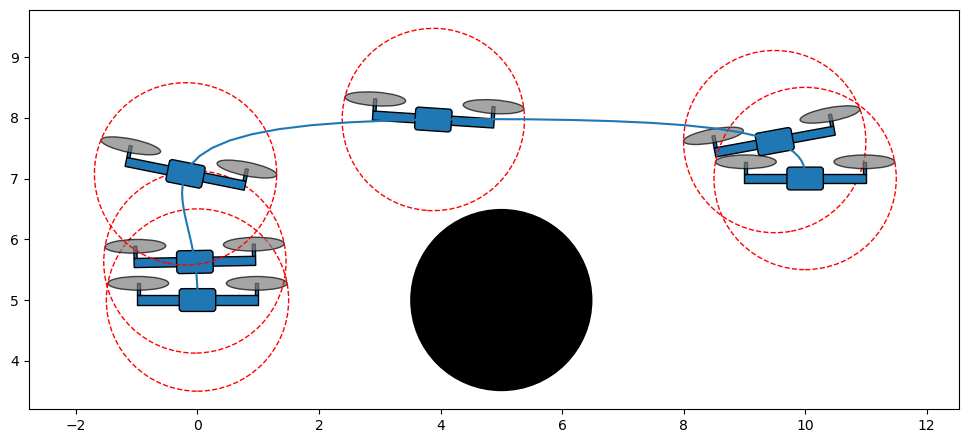

In [5]:
def simulate_nominal(initial_state, nominal_controls):
    states = [initial_state]
    for k in range(N):
        states.append(planar_quad.discrete_step(states[k], nominal_controls[k], dt))
    return np.array(states)  # Equals `nominal_states` from optimization.


fig, ax = plt.subplots(figsize=(12, 6))
plot_obstacle(ax)
planar_quad.animate(simulate_nominal(initial_state, nominal_controls), dt, ax)

## Part 3 - Simulating Open-loop control, with disturbance (wind field)

We consider applying the same sequence of controls but now with the planar quad influence by a wind field, i.e.,
$$
    \begin{bmatrix}
      \dot v_x \\ \dot v_y
    \end{bmatrix} =
    \begin{bmatrix}
      \frac{-(T_1 + T_2) \sin\phi - C_D^v v_x}{m} + \color{red}{w_x}\\
      \frac{(T_1 + T_2) \cos\phi - C_D^v v_y}{m}  - g + \color{red}{w_y}
    \end{bmatrix}.
$$
We see the quad pushed off course, hitting the obstacle, and even leaving the extent of the wind field (the wind is 0 where no arrows are drawn).

In [6]:
#@title Wind field code, including definition of `apply_wind_disturbance`.
import scipy.interpolate

np.random.seed(1)
xs, ys = np.arange(-3, 15), np.arange(3, 10)
X, Y = np.meshgrid(xs, ys, indexing="ij")
XY = np.stack([X.ravel(), Y.ravel()], -1)
# https://en.wikipedia.org/wiki/Gaussian_process with a squared exponential kernel.
Wx, Wy = np.random.multivariate_normal(np.zeros(len(XY)),
                                       np.exp(-np.sum(np.square(XY[:, None] - XY[None, :]), -1) / 16), 2)
wind = scipy.interpolate.RegularGridInterpolator((xs, ys),
                                                 np.stack([Wx, Wy], -1).reshape(X.shape + (2,)),
                                                 bounds_error=False,
                                                 fill_value=0)


def apply_wind_disturbance(state, dt):
    x, v_x, y, v_y, phi, omega = state
    dv_x, dv_y = dt * wind(np.array([x, y]))[0]
    return np.array([x, v_x + dv_x, y, v_y + dv_y, phi, omega])


def plot_nominal_trajectory(ax):
    ax.plot(*nominal_states[:, [0, 2]].T)


def plot_wind(ax):
    ax.quiver(X, Y, Wx, Wy, width=3e-3, alpha=0.2)

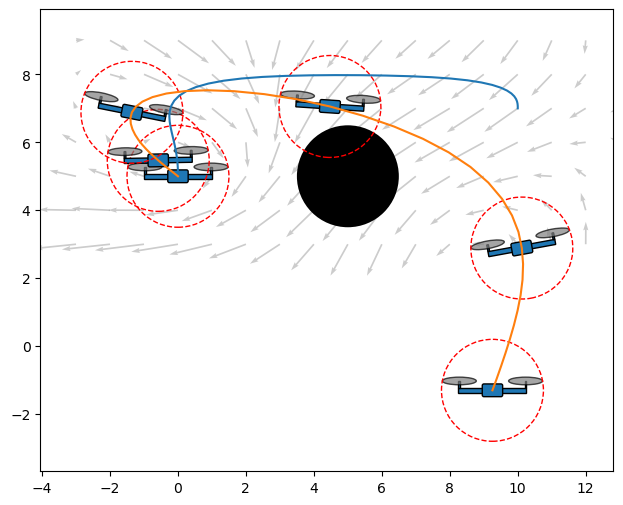

In [7]:
def simulate_open_loop(initial_state, nominal_controls):
    states = [initial_state]
    for k in range(N):
        next_state = planar_quad.discrete_step(states[k], nominal_controls[k], dt)
        next_state = apply_wind_disturbance(next_state, dt)
        states.append(next_state)
    return np.array(states)


planar_quad = PlanarQuadrotor()
fig, ax = plt.subplots(figsize=(12, 6))
plot_obstacle(ax)
plot_nominal_trajectory(ax)
plot_wind(ax)
planar_quad.animate(simulate_open_loop(initial_state, nominal_controls), dt, ax)

# Part 4 - LQR Controller and Gain Scheduling

First we need to define a gain schedule that finds the gain matrix, K, for each point along the nominal trajectory $x^*$. Given the state weighting matrix Q and control input weighting matrix R , and matrices A, and B from the linearized dynamics at a given step of the nominal trajectory, we compute the closest nominal state $\hat{x}^*_{i}$ to the drone's current state $x_{i}$, and the corresponding nominal controls $\hat{u}^*_{i}$ at each step i of the trajectory. 
$
\begin{align}
j_{closest} &= \text{argmin}_{j} \left\|x_{i} - x_j^*\right\|_{2} \\
\hat{x}^*_{i} &= x_{j_{closest}} \\
\hat{u}^*_{i} &= u_{j_{closest}}
\end{align}
$

First let's define a function that finds the closest point on the nominal trajectory for any given state x.

In [8]:
def find_closest_nominal_state(current_state):
    ################ Your code here ############################################
    # Hint: This shouldn't take more than a couple lines
    dist = np.sqrt(np.sum((nominal_states-current_state)**2,axis = 1))
    closest_state_idx = int(np.argmin(dist))
    ############################################################################
    return closest_state_idx

Next, we will calculate a gain schedule for the trajectory. A gain schedule maps each state in the open loop trajectory to a gains matrix, K. At each step of the trajectory, this matrix can be computed by using the matrix P, which is a solution of the ricatti equation. Refer to lecture notes and the hints below for the exact equations you will need!

In [9]:
from scipy.linalg import solve_continuous_are as ricatti_solver
# We will now create a gain schedule for each point in our trajectory
gains_lookup = {} # This dictionary should map each time index of the state to a gains matrix
Q = 100 * np.diag([1., 0.1, 1., 0.1, 0.1, 0.1])
R = 1e0 * np.diag([1., 1.])

for i in range(len(nominal_states)):
    #################### Your code here ##########################################
    # Hints:
    # This problem very closely follows the lecture notes! We highly recommend
    # going through them before attempting the problem if you haven't already
    # done so
    # 1. Use planar_quad.get_continuous_jacobians() to calculate the jacobians of the dynamics
    # 2. Use the import ricatti_solver function to get P. Note that this function
    # actually returns the transpose of P
    # 3. Find the gains and update the gains lookup dictionary with it
    # 4. Nominal controls are not defined for the last state. Set these to zero.
    if i == len(nominal_states) -1:
        ep = 1E-7
        u = np.full(planar_quad.u_dim,ep)
    else:
        u = nominal_controls[i]
    A,B = planar_quad.get_continuous_jacobians(nominal_states[i],u)
    P = ricatti_solver(A,B,Q,R)
    P = P.T
    K = np.linalg.inv(R)@B.T@P
    # print("K.shape = " + str(K.shape))
    ##############################################################################
    gains_lookup[i] = K

Lastly, we will implement code for closed-loop control using the LQR controller. The controls applied at a given timestep should follow the equation,

$ u = \hat{u}^*_{i} - K_i(x_i - \hat{x}^*_{i})$

where $K_i$ is the gain matrix corresponding to the closest nominal state $\hat{x}^*_{i}$ to the current state, $x_i$

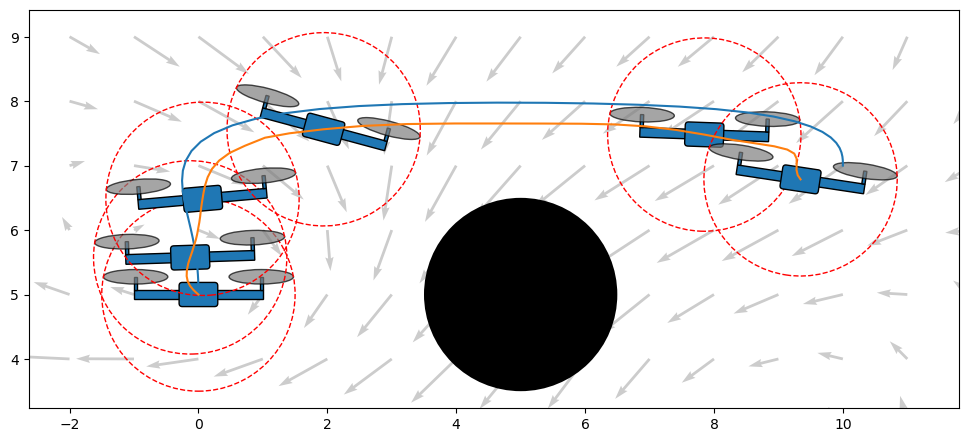

In [10]:
def simulate_closed_loop(initial_state, nominal_controls):
    states = [initial_state]
    for k in range(N):
        #################### Your code here ####################################
        # Add code to compute the new controls using the LQR controller
        # Hints:
        # 1. Find the closest nominal state to the current state and lookup
        # the corresponding gain matrix
        # 2. Use the closest nominal state, its corresponding control, and the
        # gain matrix to compute the adjusted controls for the current state
        idx = find_closest_nominal_state(states[k])
        if idx >= N:
            closest_nominal_u = np.zeros(planar_quad.udim)
        else:
            closest_nominal_u = nominal_controls[idx]
        control = closest_nominal_u - gains_lookup[idx]@(states[k] - nominal_states[idx])
        #######################################################################
        control = np.clip(control, planar_quad.min_thrust_per_prop, planar_quad.max_thrust_per_prop)
        next_state = planar_quad.discrete_step(states[k], control, dt)
        next_state = apply_wind_disturbance(next_state, dt)
        states.append(next_state)
    return np.array(states)
    
planar_quad = PlanarQuadrotor()
fig, ax = plt.subplots(figsize=(12, 6))
plot_obstacle(ax)
plot_nominal_trajectory(ax)
plot_wind(ax)
planar_quad.animate(simulate_closed_loop(initial_state, nominal_controls), dt, ax)

If your implementation is correct, the drone should now roughly track the trajectory. Please include this closed loop plot your written submission. There are also a few short answer questions you need to answer there!